In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import shuffle
from keras.utils  import to_categorical

In [2]:

import math
import random
import tempfile

def _copy_symlinks(files, src_dir, dst_dir):
    for i in files:
        base_file_name = os.path.basename(i)
        src_file_path = os.path.join(src_dir, base_file_name)
        dst_file_path = os.path.join(dst_dir, base_file_name)
        src_file_path = os.path.abspath(src_file_path)
        dst_file_path = os.path.abspath(dst_file_path)
        os.symlink(src_file_path, dst_file_path)

def train_valid_split(original_dir, validation_split=0.1, seed=None):
    if seed is not None:
        random.seed(seed)    
    if not os.path.isdir(original_dir):
        raise NotADirectoryError
    tmp_dir = tempfile.TemporaryDirectory()
    train_dir = os.path.join(tmp_dir.name, 'train')
    valid_dir = os.path.join(tmp_dir.name, 'validation')

    # make subdirs in train tmp and valid tmp
    for root, dirs, files in os.walk(original_dir):
        if root == original_dir:
            continue
        sub_dir_name = os.path.basename(root)
        train_sub_dir_path = os.path.join(train_dir, sub_dir_name)
        valid_sub_dir_path = os.path.join(valid_dir, sub_dir_name)
        if not os.path.exists(train_sub_dir_path):
            os.makedirs(train_sub_dir_path)
        if not os.path.exists(valid_sub_dir_path):
            os.makedirs(valid_sub_dir_path)

    # distribute symlinks to train_tmp, test_tmp
    for root, dirs, files in os.walk(original_dir):
        if root == original_dir:
            continue
        sub_dir_name = os.path.basename(root)
        train_sub_dir_path = os.path.join(train_dir, sub_dir_name)
        valid_sub_dir_path = os.path.join(valid_dir, sub_dir_name)
        files = [os.path.join(root, f) for f in files]
        random.shuffle(files)
        valid_idx = math.ceil(validation_split * len(files))
        train_files = files[valid_idx:]
        valid_files = files[:valid_idx]
        _copy_symlinks(train_files, root, train_sub_dir_path)
        _copy_symlinks(valid_files, root, valid_sub_dir_path)
    return tmp_dir, train_dir, valid_dir

In [3]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img
    

    return eraser

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import split_utils
# from random_eraser import get_random_eraser  # added
original_dir = '../input/cucumber7030/Cucumber/train'
batch_size = 32
validation_split = 0.1

base_dir, train_dir, val_dir = train_valid_split(original_dir, validation_split, seed=1)


train_datagen = ImageDataGenerator(
    rescale = (1./255),
    rotation_range=90,
    width_shift_range=.2,
    zoom_range=0.2,
    height_shift_range=.2,
    brightness_range=(0.9,1.5),
    horizontal_flip=True,
    preprocessing_function=get_random_eraser(v_l=0, v_h=1))

test_datagen = ImageDataGenerator(rescale = (1./255))
validation_datagen = ImageDataGenerator(rescale = (1./255))

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size= 32,
    class_mode='binary',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size= 32,
    class_mode='binary',
    shuffle=True)


Found 743 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


In [5]:
import keras 
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten
from keras.models import Sequential
from tensorflow.keras.layers import *

In [6]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3),padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3),padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))

model.add(Dense(units=1, activation="sigmoid"))



In [7]:
model.compile(optimizer= keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath = ('./rottenvsfresh_cucumber.h5')
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience = 4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

In [9]:

history = model.fit_generator(generator=train_generator,validation_data=validation_generator,
use_multiprocessing=True,
workers=6,
steps_per_epoch=math.ceil(train_generator.n//train_generator.batch_size),
epochs = 50,
validation_steps=math.ceil(validation_generator.n//validation_generator.batch_size),
callbacks=[earlyStopping, mcp_save])

model.save_weights("./rottenvsfresh_cucumber.h5")



Epoch 1/50
23/23 [==============================] - 13s 545ms/step - loss: 0.6919 - accuracy: 0.5162 - val_loss: 0.6899 - val_accuracy: 0.5469
Epoch 2/50
23/23 [==============================] - 16s 700ms/step - loss: 0.6761 - accuracy: 0.5345 - val_loss: 0.6430 - val_accuracy: 0.5938
Epoch 3/50
23/23 [==============================] - 18s 767ms/step - loss: 0.5478 - accuracy: 0.7496 - val_loss: 0.2407 - val_accuracy: 0.9844
Epoch 4/50
23/23 [==============================] - 17s 743ms/step - loss: 0.2156 - accuracy: 0.9226 - val_loss: 0.0145 - val_accuracy: 1.0000
Epoch 5/50
23/23 [==============================] - 12s 514ms/step - loss: 0.2444 - accuracy: 0.9283 - val_loss: 0.0467 - val_accuracy: 0.9844
Epoch 6/50
23/23 [==============================] - 12s 532ms/step - loss: 0.1022 - accuracy: 0.9719 - val_loss: 0.0206 - val_accuracy: 1.0000
Epoch 7/50
23/23 [==============================] - 16s 694ms/step - loss: 0.0444 - accuracy: 0.9887 - val_loss: 0.0034 - val_accuracy: 1.0000

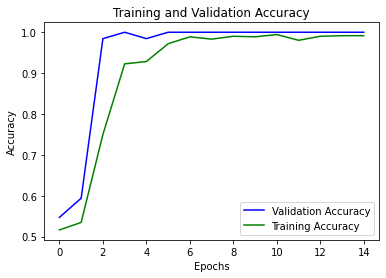

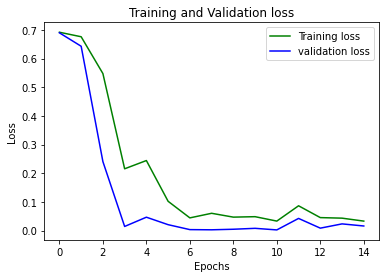

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.epoch,history.history['val_accuracy'],'-b',label='Validation Accuracy')
plt.plot(history.epoch,history.history['accuracy'],'-g',label='Training Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# print(history.history['va'])
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = history.epoch
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
model.load_weights("./rottenvsfresh_cucumber.h5")

In [12]:
model.evaluate_generator(generator=validation_generator,
steps=validation_generator.n//validation_generator.batch_size)

[0.019388550892472267, 1.0]

In [13]:
testing_generator = test_datagen.flow_from_directory(
    '../input/cucumber7030/Cucumber/test',
    target_size=(224, 224),
    batch_size= 1,
    class_mode='binary',
    shuffle=False)
STEP_SIZE_TEST=testing_generator.n
print(STEP_SIZE_TEST)
# valid_generator.reset()
pred=model.predict_generator(testing_generator,
steps=STEP_SIZE_TEST,
verbose=1)

Found 354 images belonging to 2 classes.
354
354/354 [==============================] - 3s 10ms/step


In [14]:
orignal_labels=testing_generator.labels

In [15]:
# #print(np.sum(orignal_labels))
for i in range(len(pred)):
    if pred[i]>0.5:
        pred[i]=1
    else:
        pred[i]=0
pred=pred[:,0]

In [16]:
# predicted_class_indices=np.argmax(pred,axis=1)
# print(predicted_class_indices)

labels = (testing_generator.class_indices)

labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in list(pred)]

#print(predictions)
filenames=testing_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

print(results)

                           Filename Predictions
0                    fresh/0011.jpg       fresh
1                    fresh/0014.jpg       fresh
2                    fresh/0019.jpg       fresh
3                    fresh/0021.jpg       fresh
4                    fresh/0026.jpg       fresh
..                              ...         ...
349             rotten/r_91_100.jpg      rotten
350             rotten/r_97_100.jpg      rotten
351             rotten/r_99_100.jpg      rotten
352          rotten/scab3_600px.jpg      rotten
353  rotten/white-cuke1-400x300.jpg      rotten

[354 rows x 2 columns]


In [17]:
acc=np.sum(np.array(orignal_labels)==np.array(pred))
print("Prediction Accuracy = ",acc/len(orignal_labels))

Prediction Accuracy =  0.9887005649717514
